In [1]:
import pandas as pd

In [3]:
data2009 = pd.read_csv('/home/jovyan/work/dags/data/raw/2009_sample.csv')

In [3]:
data2009.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,XE,1204,DCA,EWR,1100,1058.0,-2.0,18.0,1116.0,...,62.0,68.0,42.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,XE,1206,EWR,IAD,1510,1509.0,-1.0,28.0,1537.0,...,82.0,75.0,43.0,213.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01,XE,1207,EWR,DCA,1100,1059.0,-1.0,20.0,1119.0,...,70.0,62.0,36.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01,XE,1208,DCA,EWR,1240,1249.0,9.0,10.0,1259.0,...,77.0,56.0,37.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,XE,1209,IAD,EWR,1715,1705.0,-10.0,24.0,1729.0,...,105.0,77.0,40.0,213.0,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
aux1 = data2009.groupby(['ORIGIN','FL_DATE']).agg({'DEP_DELAY': 'mean'})

In [29]:
aux1.reset_index().head()

,ORIGIN,FL_DATE,DEP_DELAY
0,ABE,2009-01-01,-2.916667
1,ABE,2009-01-02,2.357143
2,ABE,2009-01-03,25.500000
3,ABE,2009-01-04,9.636364
4,ABE,2009-01-05,4.153846


In [30]:
aux2 = aux1.reset_index()
aux2[aux2['ORIGIN']=='ABE'].head()

,ORIGIN,FL_DATE,DEP_DELAY
0,ABE,2009-01-01,-2.916667
1,ABE,2009-01-02,2.357143
2,ABE,2009-01-03,25.500000
3,ABE,2009-01-04,9.636364
4,ABE,2009-01-05,4.153846


<AxesSubplot:xlabel='FL_DATE'>

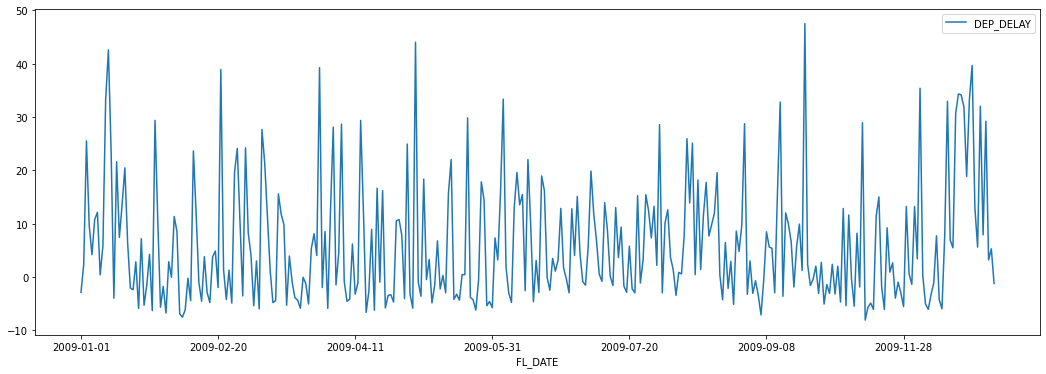

In [31]:
aux2[aux2['ORIGIN']=='ABE'].plot(x='FL_DATE', y='DEP_DELAY', figsize=(18,6))

In [67]:
from sklearn.preprocessing import StandardScaler

aux3 = aux1[aux1.index.isin(['ABE'], level=0)]

scaler = StandardScaler()
aux4 = scaler.fit_transform(aux3)

In [58]:
aux3['scaled']= aux4

/tmp/ipykernel_51/756250201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux3['scaled']= aux4


In [59]:
aux3.head()

DEP_DELAY    scaled
ORIGIN FL_DATE                        
ABE    2009-01-01  -2.916667 -0.789127
       2009-01-02   2.357143 -0.324319
       2009-01-03  25.500000  1.715381
       2009-01-04   9.636364  0.317237
       2009-01-05   4.153846 -0.165966

In [62]:
import typing
# This wrapper will apply any sklearn transform you pass into it to a group.

class SklearnWrapper:
    def __init__(self, transform: typing.Callable):
        self.transform = transform

    def __call__(self, df):
        transformed = self.transform.fit_transform(df.values)
        return pd.DataFrame(transformed, columns=df.columns, index=df.index)

In [70]:
df_rescaled = (
    aux3.groupby("ORIGIN")
    .apply(SklearnWrapper(StandardScaler()))
    .rename(columns = {'DEP_DELAY': 'SCALED'})
)
df_rescaled = aux3.join(df_rescaled, )
df_rescaled.head()

DEP_DELAY    SCALED
ORIGIN FL_DATE                        
ABE    2009-01-01  -2.916667 -0.789127
       2009-01-02   2.357143 -0.324319
       2009-01-03  25.500000  1.715381
       2009-01-04   9.636364  0.317237
       2009-01-05   4.153846 -0.165966

In [71]:
from sklearn.preprocessing import StandardScaler
import typing

# This wrapper will apply any sklearn transform you pass into it to a group.
class SklearnWrapper:
    def __init__(self, transform: typing.Callable):
        self.transform = transform

    def __call__(self, df):
        transformed = self.transform.fit_transform(df.values)
        return pd.DataFrame(transformed, columns=df.columns, index=df.index)

In [82]:
grouped = data2009.groupby(['ORIGIN','FL_DATE']).agg({'DEP_DELAY': 'mean'})

df_rescaled = (
    grouped.groupby("ORIGIN")
    .apply(SklearnWrapper(StandardScaler()))
    .rename(columns = {'DEP_DELAY': 'SCALED'})
)
df_rescaled = (
    grouped.join(df_rescaled)
    .assign(OUTLIER=(abs(df_rescaled.SCALED)>=3).astype(int))
)

df_rescaled.head()

DEP_DELAY    SCALED  OUTLIER
ORIGIN FL_DATE                                 
ABE    2009-01-01  -2.916667 -0.789127        0
       2009-01-02   2.357143 -0.324319        0
       2009-01-03  25.500000  1.715381        0
       2009-01-04   9.636364  0.317237        0
       2009-01-05   4.153846 -0.165966        0

In [76]:
df_rescaled[df_rescaled.index.isin(['EWR'], level=0)].head()

DEP_DELAY    SCALED  OUTLIER
ORIGIN FL_DATE                                 
EWR    2009-01-01   8.229299 -0.434597        0
       2009-01-02  34.076923  1.143827        0
       2009-01-03  14.925926 -0.025658        0
       2009-01-04   9.524540 -0.355502        0
       2009-01-05   7.619718 -0.471822        0

In [79]:
df_rescaled.groupby(['ORIGIN']).agg({'OUTLIER': 'sum', 'DEP_DELAY': 'count'}).sort_values(by='OUTLIER')

,OUTLIER,DEP_DELAY
ORIGIN,,
PIR,0,3
LWB,0,57
BJI,1,53
AKN,1,77
DLG,1,77
...,...,...
DSM,11,334
LYH,11,332
DBQ,11,330
